In [50]:
import importlib
import os
from joblib import dump, load

import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.preprocessing import MultiLabelBinarizer

import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"

np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format

# https://github.com/tensorflow/text/issues/476

In [2]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
# 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
# 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [3]:
# data_filename = "bs4_nltk.pkl"
data_filename = "bs4.pkl"
df_base = pd.read_pickle(data_path + data_filename)
df_top = pd.read_pickle(data_path + 'Top_Tags.pkl')
# body_corpus = load(data_path + 'body_corpus.joblib')

In [4]:
mlb = MultiLabelBinarizer()
df_tags = pd.read_pickle(data_path + 'Top_Tags.pkl')
df_tags_test = pd.read_pickle(data_path + 'Top_Tags_test.pkl')
df_tags_full = pd.concat([df_tags,df_tags_test])
mlb.fit_transform(df_tags_full['Tags_T50'])

y_tags = mlb.transform(df_tags['Tags_T50'])
y_tags_test = mlb.transform(df_tags_test['Tags_T50'])

y_tag_python = y_tags[:,np.where(mlb.classes_=="python")]

In [5]:
text_test = ['help on python array']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  2393  2006 18750  9140   102     0     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [37]:
COUNT = 100000
SPLIT_RATIO = .8
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 128

# dataset =  tf.data.Dataset.from_tensor_slices((df['Body'][:COUNT], y_tags[:COUNT]))
dataset =  tf.data.Dataset.from_tensor_slices((df_base['Bs4_Body'][:COUNT], y_tags[:COUNT]))


train_dataset, test_dataset = dataset.take(dataset.cardinality().numpy()*SPLIT_RATIO), dataset.skip(dataset.cardinality().numpy()*SPLIT_RATIO)
train_data = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_data = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [38]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.4 )(net)
#     net = tf.keras.layers.Dense(48, activation='relu', name='HIDDEN_1')(net)
#     net = tf.keras.layers.Dropout(0.25)(net)
    net = tf.keras.layers.Dense(51, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)


# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

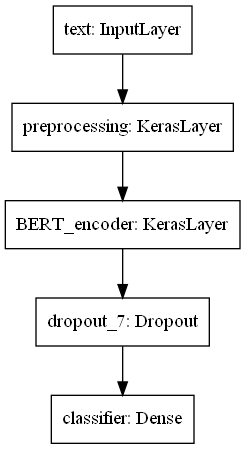

In [39]:
tf.keras.utils.plot_model(classifier_model)

In [40]:
loss = tf.keras.losses.BinaryCrossentropy(
#     from_logits=True
    )
# metrics = tf.metrics.BinaryAccuracy()
metrics = [
    tf.keras.metrics.PrecisionAtRecall(0.4, name='patr'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.FalsePositives(name='fp'),
#     keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
#     keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [41]:
classifier_model = build_classifier_model()
steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [42]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics,
#                          metrics=['AUC'],
                        )

In [43]:
epochs = 5
history = classifier_model.fit(x=train_data,
                               validation_data=test_data,
                               epochs=epochs)

Epoch 1/5
2411/2411 [==============================] - 835s 344ms/step - loss: 0.1840 - patr: 0.1340 - recall: 0.1876 - auc: 0.7506 - fp: 41788.7135 - fn: 44968.3532 - tp: 12394.2081 - accuracy: 0.9294 - precision: 0.1912 - val_loss: 0.0603 - val_patr: 0.7995 - val_recall: 0.4781 - val_auc: 0.9585 - val_fp: 4890.0000 - val_fn: 15020.0000 - val_tp: 13757.0000 - val_accuracy: 0.9798 - val_precision: 0.7378
Epoch 2/5
2411/2411 [==============================] - 703s 292ms/step - loss: 0.0610 - patr: 0.7814 - recall: 0.4731 - auc: 0.9564 - fp: 10236.0684 - fn: 29608.8375 - tp: 27754.2612 - accuracy: 0.9795 - precision: 0.7258 - val_loss: 0.0559 - val_patr: 0.8396 - val_recall: 0.5254 - val_auc: 0.9635 - val_fp: 5135.0000 - val_fn: 13658.0000 - val_tp: 15119.0000 - val_accuracy: 0.9809 - val_precision: 0.7465
Epoch 3/5
2411/2411 [==============================] - 680s 282ms/step - loss: 0.0509 - patr: 0.8621 - recall: 0.5612 - auc: 0.9712 - fp: 9805.8939 - fn: 24592.8313 - tp: 32769.8976 - 

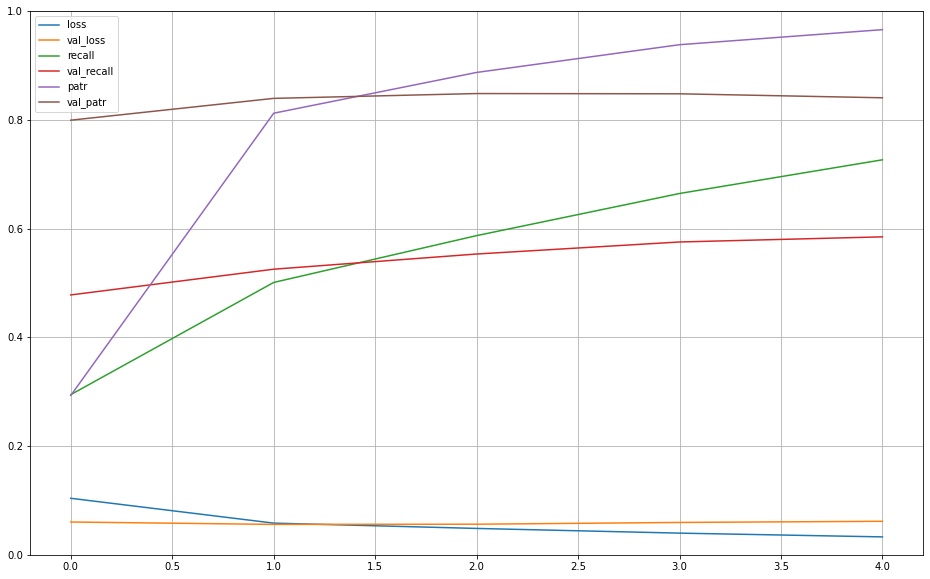

In [51]:
cols_1 = ['loss', 'val_loss', 'recall', 'val_recall', 'patr', 'val_patr' ]
pd.DataFrame(history.history)[cols_1].plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()